In [2]:
import os
import sys
import subprocess as subp
import json
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import nibabel as nib

In [3]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

In [4]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [5]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [10]:
# Set path 
#path_root = '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/'
path_pheno = '/mnt/home_sq/yassinebha/data/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/pheno/'
path_root = '/scratch/yassinebha/pleio/pleio_association/'
# Set file pattern
pedig_file_ptrn = 'solar_{}_spm_pedigre.csv'
pheno_file_ptrn = 'solar_{}_spm_{}_pheno.csv'
pheno_clust = os.path.join(path_pheno,'hcp_pleio_RhoP_pheno_nonan_norm_python_13.csv')
#pheno_clust = os.path.join(path_root,'hcp_bootstraped_pheno_nonan_norm_python_13.csv')
# Set task and trials
task_name = 'gambling'
nb_sbt= 5
list_sbt = ['sub%s' % str(i+1) for i in range(nb_sbt)]
list_trial = ['win','loss','contrast_win_vs_loss']

In [11]:
list_sbt

['sub1', 'sub2', 'sub3', 'sub4', 'sub5']

In [12]:
# Load pedig file
pedig_df = pd.read_csv(os.path.join(path_root,pedig_file_ptrn.format(str.upper(task_name))))

In [13]:
# Load subtypes weights
sbt_weight_df = pd.read_csv(os.path.join(path_root,'solar_{}_spm_{}_pheno.csv'.format(str.upper(task_name),
                                                                                 str(nb_sbt))))
sbt_weight_df.count()

ID                               799
GAM_contrast_win_vs_loss_sub1    799
GAM_contrast_win_vs_loss_sub2    799
GAM_contrast_win_vs_loss_sub3    799
GAM_contrast_win_vs_loss_sub4    799
GAM_contrast_win_vs_loss_sub5    799
GAM_loss_sub1                    799
GAM_loss_sub2                    799
GAM_loss_sub3                    799
GAM_loss_sub4                    799
GAM_loss_sub5                    799
GAM_win_sub1                     799
GAM_win_sub2                     799
GAM_win_sub3                     799
GAM_win_sub4                     799
GAM_win_sub5                     799
Age_in_Yrs                       799
Gender                           799
BMI                              799
GAM_FD_mean                      799
GAM_FD_scrubbed_mean             799
dtype: int64

In [14]:
# Load phenotype clustered file
#pheno_clust_df = pd.read_csv(pheno_clust).rename(columns={'Subject': 'ID'})
pheno_clust_df = pd.read_csv(pheno_clust)
#pheno_clust_df.loc[:,'ID'] = 'HCP' + pheno_clust_df['ID'].astype(str)
pheno_clust_df.head()

,ID,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13
0,HCP100004,0.466965,0.085162,0.398510,1.185358,-1.530547,-1.051773,0.290558,-0.151578,-0.649200,-0.538317,0.257666,0.252343,-0.279920
1,HCP100206,0.706008,1.436342,1.975280,1.283574,-0.510366,-1.143145,0.556350,0.055734,0.084439,1.301892,-0.077159,0.091172,0.052662
2,HCP100307,-0.559144,-0.713226,-0.703027,0.522789,-0.140952,-0.528705,-0.119682,0.195018,-0.384303,0.492726,0.136348,-0.662889,-0.952467
3,HCP100408,-0.109229,-0.034026,-0.589268,0.092160,0.221359,-0.237051,-1.626095,-0.133106,0.927576,0.018709,0.176793,1.069077,-0.521888
4,HCP100610,-0.575076,-0.386394,0.203063,-0.361182,-0.197974,2.017489,0.519531,0.582089,1.141519,0.894110,0.202821,0.812544,-0.881930


In [15]:
# Clusters list
list_pheno_clust = [x for x in pheno_clust_df.columns.get_values() if x!='ID']
list_pheno_clust

['Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'Cluster_5',
 'Cluster_6',
 'Cluster_7',
 'Cluster_8',
 'Cluster_9',
 'Cluster_10',
 'Cluster_11',
 'Cluster_12',
 'Cluster_13']

In [16]:
# Merge pheno clusters with subtypes
sbt_pheno_df = pd.merge(sbt_weight_df,pheno_clust_df,how='left',on='ID')
sbt_pheno_df

,ID,GAM_contrast_win_vs_loss_sub1,GAM_contrast_win_vs_loss_sub2,GAM_contrast_win_vs_loss_sub3,GAM_contrast_win_vs_loss_sub4,GAM_contrast_win_vs_loss_sub5,GAM_loss_sub1,GAM_loss_sub2,GAM_loss_sub3,GAM_loss_sub4,...,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13
0,HCP100206,0.249,-0.110,-0.092,0.346,-0.320,-0.366,-0.153,-0.089,-0.256,...,1.283574,-0.510366,-1.143145,0.556350,0.055734,0.084439,1.301892,-0.077159,0.091172,0.052662
1,HCP100307,0.242,-0.151,-0.065,0.343,-0.300,-0.342,-0.262,-0.094,-0.223,...,0.522789,-0.140952,-0.528705,-0.119682,0.195018,-0.384303,0.492726,0.136348,-0.662889,-0.952467
2,HCP100408,0.261,-0.183,0.141,0.062,-0.203,0.380,0.256,0.189,0.136,...,0.092160,0.221359,-0.237051,-1.626095,-0.133106,0.927576,0.018709,0.176793,1.069077,-0.521888
3,HCP100610,0.147,-0.262,0.291,-0.189,0.039,-0.346,-0.209,-0.035,-0.288,...,-0.361182,-0.197974,2.017489,0.519531,0.582089,1.141519,0.894110,0.202821,0.812544,-0.881930
4,HCP101006,-0.275,0.271,-0.133,-0.064,0.148,-0.182,-0.168,-0.086,-0.098,...,0.037740,-0.309221,0.589939,-1.023081,-0.181432,-0.978704,-1.191134,-0.134345,0.443699,0.055531
5,HCP101107,-0.047,0.221,-0.218,0.105,-0.065,-0.075,0.162,0.224,-0.172,...,0.202094,0.352401,-0.237178,-0.698524,-0.933695,0.278780,-0.055373,1.471619,-0.558701,0.163451
6,HCP101309,-0.002,-0.058,-0.020,0.107,-0.029,0.178,-0.049,-0.159,0.268,...,-1.054605,0.398342,2.455145,-0.285375,-0.649485,-0.505237,-0.640932,0.171810,-0.487710,-0.307215
7,HCP101410,-0.188,-0.096,0.215,-0.346,0.342,0.172,0.437,0.150,0.013,...,-0.213178,0.390266,-0.737466,0.621544,-0.951644,-0.138672,-0.286932,-0.565053,0.648836,-0.409235
8,HCP101915,-0.060,0.057,-0.064,-0.040,0.076,0.189,0.450,-0.119,0.156,...,-0.837023,1.175929,1.457978,2.486260,-0.090401,0.567062,-1.096749,0.334204,-0.916300,-0.057703
9,HCP102008,0.186,-0.132,0.107,0.066,-0.165,-0.019,0.096,-0.064,0.121,...,-0.101898,0.656850,-0.890857,0.831068,0.283298,0.278978,0.786314,-0.202248,0.735288,0.151105


In [17]:
# check if any NaN value present
sbt_pheno_df.isnull().values.sum()

0

In [18]:
sbt_pheno_df.count()

ID                               799
GAM_contrast_win_vs_loss_sub1    799
GAM_contrast_win_vs_loss_sub2    799
GAM_contrast_win_vs_loss_sub3    799
GAM_contrast_win_vs_loss_sub4    799
GAM_contrast_win_vs_loss_sub5    799
GAM_loss_sub1                    799
GAM_loss_sub2                    799
GAM_loss_sub3                    799
GAM_loss_sub4                    799
GAM_loss_sub5                    799
GAM_win_sub1                     799
GAM_win_sub2                     799
GAM_win_sub3                     799
GAM_win_sub4                     799
GAM_win_sub5                     799
Age_in_Yrs                       799
Gender                           799
BMI                              799
GAM_FD_mean                      799
GAM_FD_scrubbed_mean             799
Cluster_1                        799
Cluster_2                        799
Cluster_3                        799
Cluster_4                        799
Cluster_5                        799
Cluster_6                        799
C

### Pleiothropy estimate:

In [19]:
import collections
import multiprocessing 
import datetime

In [20]:
#initiate empty dictionary
Pleio_Asso = collections.namedtuple('Pleio_Asso', [
    'out_dir',
    'pedig_f',
    'pheno_f',
    'var_1',
    'var_2',
    'covar_1'
])
pleio_asso = []

# pleio root folder
path_pleio = os.path.join(path_root,'pleio_{}_{}'.format(str(datetime.date.today()),
                                                        task_name))
if not os.path.exists(path_pleio):
    os.makedirs(path_pleio)

# create ouput folders and populate RhoG dictionnary
for ix_trial, trial in enumerate(list_trial):
    for ix_clust, clust in enumerate(list_pheno_clust):
        for ix_subt, subt in enumerate(list_sbt):
            print(trial,clust,subt)
            pheno_1 = clust
            pheno_2 = '{}_{}_{}'.format(str.upper(task_name)[:3],trial,subt)
            cov_1 = '{}_FD_scrubbed_mean'.format(str.upper(task_name)[:3])
            
            # output result folder 
            path_pleio_contrast = os.path.join(path_pleio,'{}_{}_{}'.format(trial,clust,subt))
            if not os.path.exists(path_pleio_contrast):
                os.makedirs(path_pleio_contrast)
            
            # copy needed files to output folder
            if not os.path.isfile(os.path.join(path_pleio_contrast,'se_univ_polygen.tcl')):
                subp.run(['cp',os.path.join(path_root,'se_univ_polygen.tcl'),path_pleio_contrast])
            if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_run.sh')):
                subp.run(['cp',os.path.join(path_root,'pleio_run.sh'),path_pleio_contrast])
        
            # pedegree
            if not os.path.isfile(os.path.join(path_pleio_contrast,pedig_file_ptrn.format(str.upper(task_name)))):
                subp.run(['cp',os.path.join(path_root,pedig_file_ptrn.format(str.upper(task_name))),path_pleio_contrast]) 

            pedig_f = os.path.join(path_pleio_contrast,pedig_file_ptrn.format(str.upper(task_name)))

            # save pheno cov to file
            pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
            if not os.path.isfile(pheno_f):
                sbt_pheno_df[['ID','Age_in_Yrs','Gender',pheno_1,pheno_2,cov_1]].to_csv(pheno_f,index=False)   

            # collect all pleio contrasts in dictionary
            pleio_asso.append(Pleio_Asso(out_dir = path_pleio_contrast,
                                          pedig_f = pedig_f,
                                          pheno_f = pheno_f,
                                          var_1 = pheno_1,
                                          var_2 = pheno_2,
                                          covar_1 = cov_1)) 

win Cluster_1 sub1
win Cluster_1 sub2
win Cluster_1 sub3
win Cluster_1 sub4
win Cluster_1 sub5
win Cluster_2 sub1
win Cluster_2 sub2
win Cluster_2 sub3
win Cluster_2 sub4
win Cluster_2 sub5
win Cluster_3 sub1
win Cluster_3 sub2
win Cluster_3 sub3
win Cluster_3 sub4
win Cluster_3 sub5
win Cluster_4 sub1
win Cluster_4 sub2
win Cluster_4 sub3
win Cluster_4 sub4
win Cluster_4 sub5
win Cluster_5 sub1
win Cluster_5 sub2
win Cluster_5 sub3
win Cluster_5 sub4
win Cluster_5 sub5
win Cluster_6 sub1
win Cluster_6 sub2
win Cluster_6 sub3
win Cluster_6 sub4
win Cluster_6 sub5
win Cluster_7 sub1
win Cluster_7 sub2
win Cluster_7 sub3
win Cluster_7 sub4
win Cluster_7 sub5
win Cluster_8 sub1
win Cluster_8 sub2
win Cluster_8 sub3
win Cluster_8 sub4
win Cluster_8 sub5
win Cluster_9 sub1
win Cluster_9 sub2
win Cluster_9 sub3
win Cluster_9 sub4
win Cluster_9 sub5
win Cluster_10 sub1
win Cluster_10 sub2
win Cluster_10 sub3
win Cluster_10 sub4
win Cluster_10 sub5
win Cluster_11 sub1
win Cluster_11 sub2
win C

In [21]:
def run_pleio(x):
    subp.run(['bash', os.path.join(x.out_dir,'pleio_run.sh'),
              x.out_dir,
              x.pedig_f,
              x.pheno_f,
              x.var_1,
              x.var_2,
              x.covar_1,
             ])
    
    # collect result
    RhoE = ''
    RhoE_pval=''
    RhoG = ''
    RhoG_pval_0 = ''
    RhoG_pval_1 = ''
    results = ''
    
    contrast_name = '{}_{}'.format(x.var_1,x.var_2)
    fp = open(os.path.join(x.out_dir,'solar_pleio.out'))
    for i,line in enumerate(fp):
        if 'CONVERGENCE FAILURE' in line:
            print('{}_{}'.format(x.var1,x.var_2))
            print(line)
            results = {'contrast_name' : contrast_name,'no_converg' : True}
            break
        if 'RhoE is ' in line:
            RhoE = float(line.strip('\n').split(' ')[3])
            RhoE_pval = float(line.strip('\n').split(' ')[-1])
        if 'RhoG is ' in line:
            RhoG = float(line.strip('\n').split(' ')[-1])
            #print(out_dir)
            #print(line.strip('\t ').strip('\n'))
        if 'RhoG different from zero' in line:
            RhoG_pval_0 = float(line.strip('\n').split(' ')[-1])
            #print(line.strip('\t '))
        if 'RhoG different from -1.0' in line:
            RhoG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
        elif 'RhoG different from 1.0' in line:
            RohG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
    return results

In [22]:
# function from http://danshiebler.com/2016-09-14-parallel-progress-bar/
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=12, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out

In [23]:
result = parallel_process(pleio_asso,run_pleio,use_kwargs=False)

100%|██████████| 192/192 [02:20<00:00, 1.37it/s] 
192it [00:00, 284259.22it/s]


In [24]:
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    result = executor.map(run_pleio,pleio_asso)

In [25]:
#pool = multiprocessing.Pool()
#result = pool.map(run_pleio,pleio_asso)

In [26]:
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = True):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    # replace 0's by 1
    flatt[flatt == 0] =1
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) for ii in fdr_2d] 
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

In [27]:
# Cluaters from  correlation
dict_clusters = {'Cluster_1' : 'Self_regul',
                 'Cluster_2' : 'Physio',
                 'Cluster_3' : 'Executive',
                 'Cluster_4' : 'Neg_affec',
                 'Cluster_5' : 'Somatic',
                 'Cluster_6' : 'Speed',
                 'Cluster_7' : 'Desord_ext',
                 'Cluster_8' : 'Fitness',
                 'Cluster_9' : 'Pos_affetc',
                 'Cluster_10' : 'Mem_att_mot',
                 'Cluster_11' : 'Desord_int',
                 'Cluster_12' : 'Sens_mot',
                 'Cluster_13' : 'Fluid_intel'}

In [28]:
# Clusters from RhoP corelation 
dict_clusters = {'Cluster_1' : 'Desord_ext',
                 'Cluster_2' : 'Somatic',
                 'Cluster_3' : 'Desord_int',
                 'Cluster_4' : 'Neg_affec',
                 'Cluster_5' : 'Pos_affetc',
                 'Cluster_6' : 'Self_regul',
                 'Cluster_7' : 'Fluid_intel',
                 'Cluster_8' : 'Mem_att_mot',
                 'Cluster_9' : 'Academic_comp',
                 'Cluster_10' : 'Executive',
                 'Cluster_11' : 'Sens_Emo_Fit',
                 'Cluster_12' : 'Physio',
                 'Cluster_13' : 'Speed'}

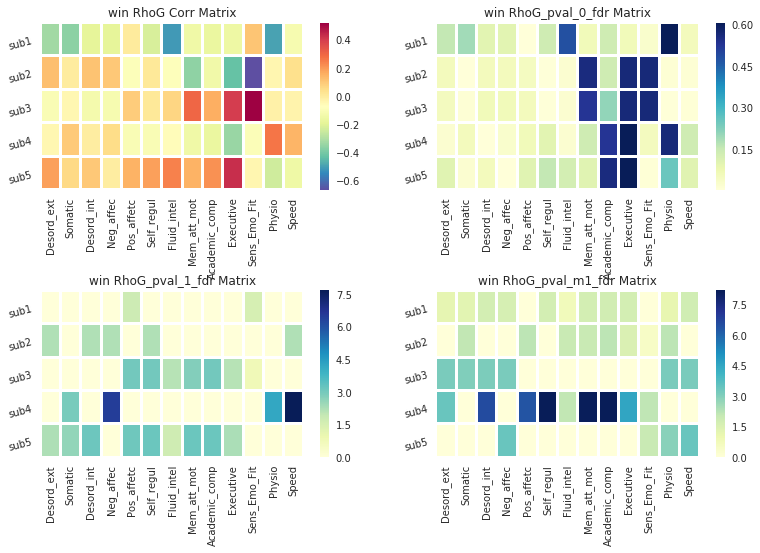

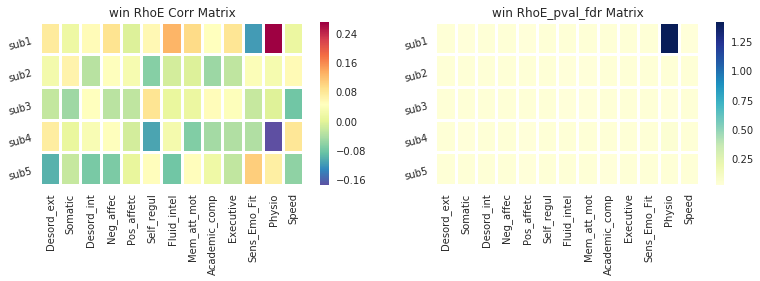

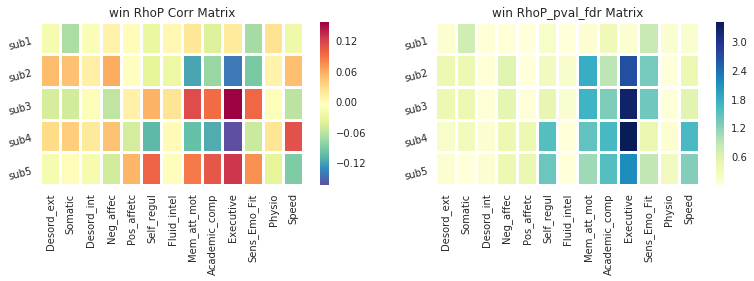

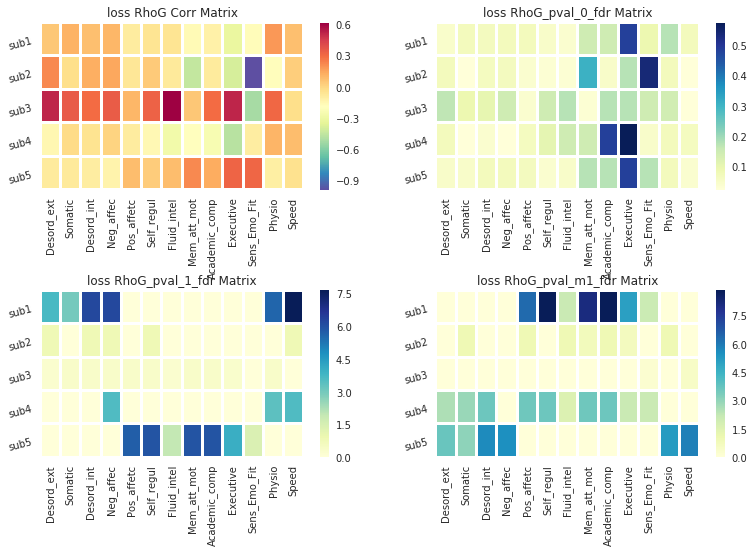

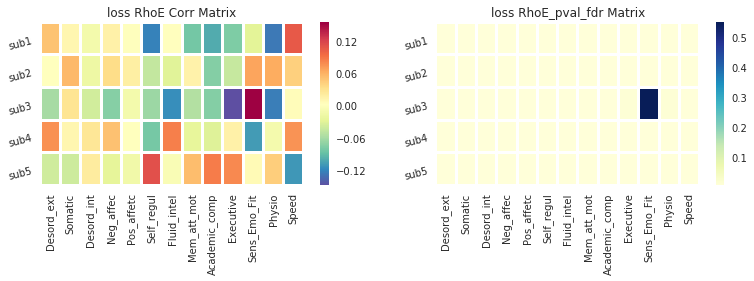

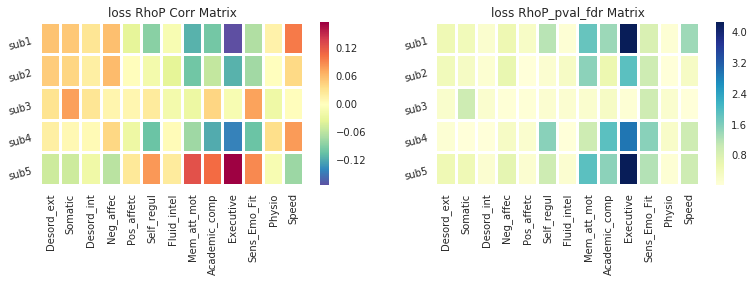

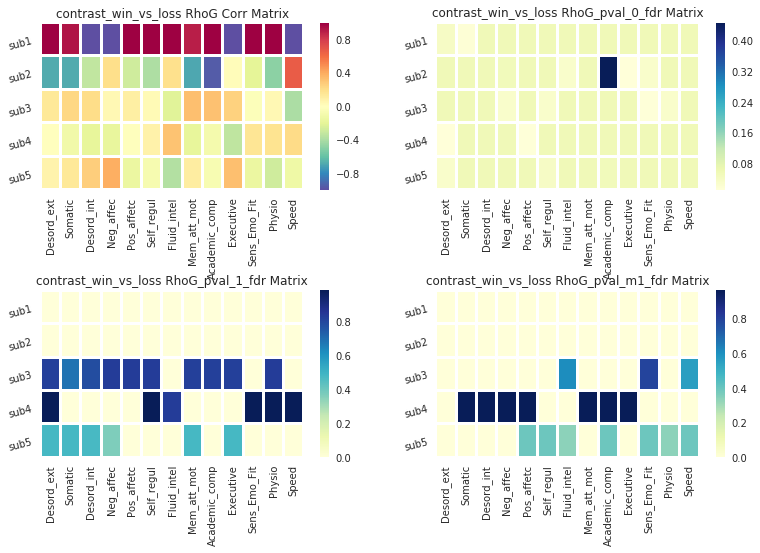

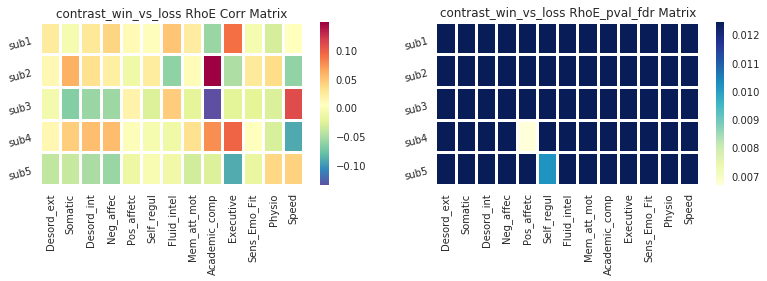

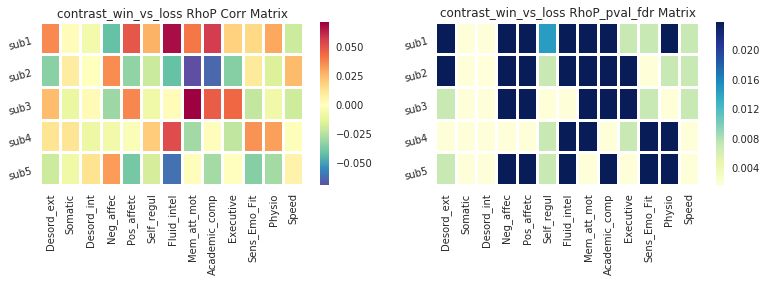

In [29]:
#Initiate no convergence result stack
No_converge = collections.namedtuple('No_converge', ['var_1',
                                                     'var_2',
                                                     'covar_1',
                                                     'pedig_f',
                                                     'pheno_f',
                                                     'out_dir'])
no_converges = []
all_resu = dict()
count =0
for ix_trial, trial in enumerate(list_trial):
    # initiate empty matrix
    RhoG = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_0 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_1 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_m1 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoE = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoE_pval = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoP = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoP_pval = np.zeros((len(list_sbt),len(list_pheno_clust)))
     
    # Loop over cluster
    for ix_clust, clust in enumerate(list_pheno_clust):
        for ix_subt, subt in enumerate(list_sbt):
            
            pheno_1 = clust
            pheno_2 = '{}_{}_{}'.format(str.upper(task_name),trial,subt)
            cov_1 = '{}_FD_scrubbed_mean'.format(str.upper(task_name))
            
            # output result folder 
            out_dir = os.path.join(path_pleio,'{}_{}_{}'.format(trial,clust,subt))
            pedig_f = os.path.join(out_dir,pedig_file_ptrn.format(str.upper(task_name)))
            
            # pheno cov file
            pheno_f= os.path.join(out_dir,'pheno_cov.csv')
            # pedig file
            pedig_f = os.path.join(out_dir,'pleio_all_pheno_pedig.csv')
            
            #grab results from text file
            fp = open(os.path.join(path_pleio,out_dir,'solar_pleio.out'))
            for i,line in enumerate(fp):
                if 'CONVERGENCE FAILURE' in line:
                    print(out_dir)
                    print(line)
                    count+=1
                    no_converges.append(No_converge(var_1 = pheno_1,
                                                    var_2 = pheno_2,
                                                    covar_1 = cov_1,
                                                    out_dir = out_dir,
                                                    pedig_f = pedig_f,
                                                    pheno_f = pedig_f))
                    break
                    
                if 'RhoE is ' in line:
                    RhoE[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[3])
                    RhoE_pval[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoG is ' in line:
                    RhoG[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                    #print(out_dir)
                    #print(line.strip('\t ').strip('\n'))
                if 'RhoG different from zero' in line:
                    RhoG_pval_0[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                    #print(line.strip('\t '))
                if 'RhoG different from -1.0' in line:
                    RhoG_pval_m1[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                elif 'RhoG different from 1.0' in line:
                    RhoG_pval_1[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoP is ' in line:
                    #print(float(line.strip('\n').split(' ')[-1]))
                    RhoP[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoP different from zero' in line:
                    RhoP_pval[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    #print(float(line.strip('\n').split(' ')[-1]))
                    break
    # save matrices
    all_resu.update({'{}'.format(trial):{'RhoE':RhoE,
                                         'RhoE_pval':RhoE_pval,
                                         'RhoE_pval_fdr':fdr_transf(RhoE_pval),
                                         'RhoG':RhoG,
                                         'RhoG_pval_0':RhoG_pval_0,
                                         'RhoG_pval_0_fdr':fdr_transf(RhoG_pval_0),
                                         'RhoG_pval_1':RhoG_pval_1,
                                         'RhoG_pval_1_fdr':fdr_transf(RhoG_pval_1),
                                         'RhoG_pval_m1':RhoG_pval_m1,
                                         'RhoG_pval_m1_fdr':fdr_transf(RhoG_pval_m1),
                                         'RhoP':RhoP,
                                         'RhoP_pval':RhoP_pval,
                                         'RhoP_pval_fdr':fdr_transf(RhoP_pval)
                                        }})
    
    ## Plot and save all results
    
    # save RhoG to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG')))
    # plot RhoG result
    f, axes = plt.subplots(2, 2,figsize = (13,8))
    f.subplots_adjust(hspace= .6)
    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,linewidths=2,ax=axes[0][0])
    axes[0][0].set_yticklabels(list_sbt, rotation=15)
    axes[0][0].set_title('{} RhoG Corr Matrix'.format(trial))
    
    # save RhoG_pval_0_fdr to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_0_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_0_fdr')))
    # plot RhoG_pval_0_fdr result
    sns.heatmap(resul_,cmap="YlGnBu",linewidths=2,ax=axes[0][1])
    axes[0][1].set_yticklabels(list_sbt, rotation=15)
    axes[0][1].set_title('{} RhoG_pval_0_fdr Matrix'.format(trial))
    
    # save RhoG_pval_1_fdr to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_1_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_1_fdr')))
    # plot RhoG_pval_1_fdr result
    sns.heatmap(resul_,cmap="YlGnBu",linewidths=2,ax=axes[1][0])
    axes[1][0].set_yticklabels(list_sbt, rotation=15)
    axes[1][0].set_title('{} RhoG_pval_1_fdr Matrix'.format(trial))
    
    # save RhoG_pval_m1_fdr to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_m1_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_m1_fdr')))
    # plot RhoG_pval_1_fdr result
    sns.heatmap(resul_,cmap="YlGnBu",linewidths=2,ax=axes[1][1])
    axes[1][1].set_yticklabels(list_sbt, rotation=15)
    axes[1][1].set_title('{} RhoG_pval_m1_fdr Matrix'.format(trial))
    
    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoG_{}.svg'.format(trial)))
    
    # save RhoE to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE')))
    # plot RhoE result
    f, axes = plt.subplots(1, 2,figsize = (13,3))
    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,linewidths=2,ax=axes[0])
    axes[0].set_yticklabels(list_sbt, rotation=15)
    axes[0].set_title('{} RhoE Corr Matrix'.format(trial))
    
    # save RhoE_pval_fdr to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE_pval_fdr')))
    # plot RhoE_pval_fdr result
    sns.heatmap(resul_,cmap="YlGnBu",linewidths=2,ax=axes[1])
    axes[1].set_yticklabels(list_sbt, rotation=15)
    axes[1].set_title('{} RhoE_pval_fdr Matrix'.format(trial))
    
    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoE_{}.svg'.format(trial)))
    
    # save RhoP to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP')))
    # plot RhoP result
    f, axes = plt.subplots(1, 2,figsize = (13,3))
    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,linewidths=2,ax=axes[0])
    axes[0].set_yticklabels(list_sbt, rotation=15)
    axes[0].set_title('{} RhoP Corr Matrix'.format(trial))
    
    # save RhoP_pval_fdr to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP_pval_fdr')))
    # plot RhoP_pval_fdr result
    sns.heatmap(resul_,cmap="YlGnBu",linewidths=2,ax=axes[1])
    axes[1].set_yticklabels(list_sbt, rotation=15)
    axes[1].set_title('{} RhoP_pval_fdr Matrix'.format(trial))
    
    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoP_{}.svg'.format(trial)))
    

# Save all results
np.save(os.path.join(path_pleio,'pleio_all_resuts.npy'),all_resu)